# Place Recognition Failure Case Analysis

This notebook analyzes failure patterns in place recognition models by examining retrieval results and visualizing query-database correspondences through recall matrices.

## Workflow
1. Configure analysis parameters (dataset, model, directories)
2. Load evaluation results with automated file discovery
3. Generate recall matrices and identify failure patterns
4. Perform detailed analysis of worst-performing query-database pairs

In [1]:
"""Import required libraries for place recognition failure analysis."""

import re
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
import torchshow as ts

from opr.testers.place_recognition.model import RetrievalResultsCollection
from mssplace.datasets import NCLTDatasetWithText, OxfordDatasetWithText

print("Libraries imported successfully")

INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.
/home/docker_mssplace/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [2]:
"""Verify evaluation results directory exists."""

RESULTS_DIR = Path().cwd() / "evaluation_results"
if not RESULTS_DIR.exists():
    print(f"ERROR: Results directory not found: {RESULTS_DIR}")
    print("Please ensure evaluation results exist before running analysis.")
else:
    print(f"Results directory found: {RESULTS_DIR}")

Results directory found: /home/docker_mssplace/MSSPlace/scripts/evaluation/evaluation_results


In [3]:
"""Configure visualization settings for consistent plot appearance."""

plt.rcParams.update({"figure.dpi": 100, "savefig.dpi": 300, "font.size": 12})
sns.set_style("whitegrid")
print("Visualization settings configured")

Visualization settings configured


In [4]:
# =============================================================================
# ANALYSIS CONFIGURATION
# =============================================================================

"""Configuration parameters for failure analysis."""

# Dataset and model selection
DATASET = "nclt"  # Options: 'oxford', 'nclt'
MODEL_NAME = "mssplace-lis"  # Options: 'mssplace-li', 'mssplace-lis', 'mssplace-lit', 'mssplace-list'

# Data directory configuration
DATA_DIR = Path("/home/docker_mssplace/Datasets/OpenPlaceRecognition")
DATA_DIR = DATA_DIR / "NCLT_preprocessed" if DATASET == "nclt" else DATA_DIR / "pnvlad_oxford_robotcar"

# Sensor configurations for different model variants
# li: LiDAR + Images, lis: + Semantic masks, lit: + Text descriptions, list: all modalities
SENSOR_CONFIGS = {
    "oxford": {
        "mssplace-li": [
            "pointcloud_lidar",
            "image_stereo_centre",
            "image_mono_left",
            "image_mono_rear",
            "image_mono_right",
        ],
        "mssplace-lis": [
            "pointcloud_lidar",
            "image_stereo_centre",
            "image_mono_left",
            "image_mono_rear",
            "image_mono_right",
            "mask_stereo_centre",
            "mask_mono_left",
            "mask_mono_rear",
            "mask_mono_right",
        ],
        "mssplace-lit": [
            "pointcloud_lidar",
            "image_stereo_centre",
            "image_mono_left",
            "image_mono_rear",
            "image_mono_right",
            "text_stereo_centre",
            "text_mono_left",
            "text_mono_rear",
            "text_mono_right",
        ],
        "mssplace-list": [
            "pointcloud_lidar",
            "image_stereo_centre",
            "image_mono_left",
            "image_mono_rear",
            "image_mono_right",
            "mask_stereo_centre",
            "mask_mono_left",
            "mask_mono_rear",
            "mask_mono_right",
            "text_stereo_centre",
            "text_mono_left",
            "text_mono_rear",
            "text_mono_right",
        ],
    },
    "nclt": {
        "mssplace-li": [
            "pointcloud_lidar",
            "image_Cam1",
            "image_Cam2",
            "image_Cam3",
            "image_Cam4",
            "image_Cam5",
        ],
        "mssplace-lis": [
            "pointcloud_lidar",
            "image_Cam1",
            "image_Cam2",
            "image_Cam3",
            "image_Cam4",
            "image_Cam5",
            "mask_Cam1",
            "mask_Cam2",
            "mask_Cam3",
            "mask_Cam4",
            "mask_Cam5",
        ],
        "mssplace-lit": [
            "pointcloud_lidar",
            "image_Cam1",
            "image_Cam2",
            "image_Cam3",
            "image_Cam4",
            "image_Cam5",
            "text_Cam1",
            "text_Cam2",
            "text_Cam3",
            "text_Cam4",
            "text_Cam5",
        ],
        "mssplace-list": [
            "pointcloud_lidar",
            "image_Cam1",
            "image_Cam2",
            "image_Cam3",
            "image_Cam4",
            "image_Cam5",
            "mask_Cam1",
            "mask_Cam2",
            "mask_Cam3",
            "mask_Cam4",
            "mask_Cam5",
            "text_Cam1",
            "text_Cam2",
            "text_Cam3",
            "text_Cam4",
            "text_Cam5",
        ],
    },
}

# Validate configuration
assert DATASET in ["oxford", "nclt"], f"Invalid dataset: {DATASET}"
assert MODEL_NAME in SENSOR_CONFIGS[DATASET], f"Invalid model for {DATASET}: {MODEL_NAME}"

print(f"Configuration set: {DATASET.upper()} dataset with {MODEL_NAME} model")
print(f"Data directory: {DATA_DIR}")
print(f"Sensors: {len(SENSOR_CONFIGS[DATASET][MODEL_NAME])} modalities")

Configuration set: NCLT dataset with mssplace-lis model
Data directory: /home/docker_mssplace/Datasets/OpenPlaceRecognition/NCLT_preprocessed
Sensors: 11 modalities


In [5]:
"""Utility functions for file discovery and dataset creation."""


def find_most_recent_results(results_dir: Path, dataset: str, model: str) -> Path | None:
    """Find the most recent results file for a given dataset and model.

    Searches for files matching pattern: {dataset}_{model}_results_{timestamp}.json
    where timestamp format is YYYYMMDD_HHMMSS.

    Args:
        results_dir: Directory containing results files
        dataset: Dataset name (e.g., 'nclt', 'oxford')
        model: Model name (e.g., 'mssplace-lis')

    Returns:
        Path to most recent results file, or None if no matching files found
    """
    if not results_dir.exists():
        print(f"WARNING: Results directory does not exist: {results_dir}")
        return None

    pattern = f"{dataset}_{model}_results_*.json"
    matching_files = list(results_dir.glob(pattern))

    if not matching_files:
        print(f"ERROR: No results files found matching pattern: {pattern}")
        print(f"Search directory: {results_dir}")
        return None

    print(f"Found {len(matching_files)} matching files")

    # Parse timestamps and sort by most recent
    files_with_timestamps = []
    for file_path in matching_files:
        match = re.search(r"_(\d{8}_\d{6})\.json$", file_path.name)
        if match:
            timestamp_str = match.group(1)
            try:
                timestamp = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
                files_with_timestamps.append((file_path, timestamp))
                print(f"  {file_path.name} -> {timestamp.strftime('%Y-%m-%d %H:%M:%S')}")
            except ValueError as e:
                print(f"WARNING: Could not parse timestamp from {file_path.name}: {e}")
        else:
            print(f"WARNING: No timestamp found in filename: {file_path.name}")

    if not files_with_timestamps:
        print("ERROR: No files with valid timestamps found")
        return None

    # Sort by timestamp (most recent first)
    files_with_timestamps.sort(key=lambda x: x[1], reverse=True)
    most_recent_file, most_recent_timestamp = files_with_timestamps[0]

    print("\nMost recent file:")
    print(f"  File: {most_recent_file.name}")
    print(f"  Timestamp: {most_recent_timestamp.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"  Size: {most_recent_file.stat().st_size / 1024:.1f} KB")

    return most_recent_file


def create_dataset(dataset_name: str, data_dir: Path, sensor_setup: list[str]) -> torch.utils.data.Dataset:
    """Create dataset instance with specified sensor configuration.

    Uses text-enabled dataset classes for compatibility with all model variants.

    Args:
        dataset_name: Dataset name ('oxford' or 'nclt')
        data_dir: Path to dataset directory
        sensor_setup: List of sensors/modalities to load

    Returns:
        Dataset instance ready for testing
    """
    print(f"Creating {dataset_name} dataset from: {data_dir}")
    print(f"Sensor setup: {sensor_setup}")

    if dataset_name == "oxford":
        dataset = OxfordDatasetWithText(
            dataset_root=data_dir,
            subset="test",
            data_to_load=sensor_setup,
            pointcloud_quantization_size=0.01,
        )
    elif dataset_name == "nclt":
        dataset = NCLTDatasetWithText(
            dataset_root=data_dir,
            subset="test",
            data_to_load=sensor_setup,
        )
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    print(f"Dataset created with {len(dataset)} samples")
    return dataset


def format_percentage(value: float) -> str:
    """Format decimal value as percentage with 2 decimal places (truncated)."""
    integer_part = int(value * 100)
    decimal_part = int((value * 100) % 1 * 100)
    return f"{integer_part}.{decimal_part:02d}%"


def plot_and_save_pc(pc: np.ndarray | Tensor, output_path: Path | str) -> None:
    """Plot and save a 3D point cloud to a file.
    Args:
        pc: Point cloud data as a NumPy array or PyTorch tensor of shape (N, 3)
        output_path: Path to save the plot image
    """
    if isinstance(pc, Tensor):
        pc = pc.numpy()
    pc = pc[np.linalg.norm(pc, axis=1) < 30]
    pc = pc[np.abs(pc[:, 2]) < 10]

    x = pc[:, 0]
    y = pc[:, 1]
    z = -pc[:, 2]

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, s=0.05, c=z)  # s is the size of the points
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_zlim(-1, 5)
    ax.view_init(elev=60, azim=180)

    ax.axis('off')
    # save the plot
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()


print("Utility functions defined")


Utility functions defined


## Data Loading and Results Discovery

Automatically discover the most recent evaluation results and load the corresponding dataset for analysis.

In [6]:
"""Find and load the most recent evaluation results."""

print(f"Searching for: {DATASET}_{MODEL_NAME}_results_*.json")

results_file = find_most_recent_results(RESULTS_DIR, DATASET, MODEL_NAME)
if not results_file:
    print(f"\nAvailable files in {RESULTS_DIR}:")
    for file in sorted(RESULTS_DIR.glob("*.json")):
        print(f"  {file.name}")
    raise FileNotFoundError(f"No results file found for {DATASET} + {MODEL_NAME}")

# Load the results collection
results = RetrievalResultsCollection.load(results_file)
print(f"Loaded {len(results)} result pairs from: {results_file.name}")

Searching for: nclt_mssplace-lis_results_*.json
Found 1 matching files
  nclt_mssplace-lis_results_20250525_165818.json -> 2025-05-25 16:58:18

Most recent file:
  File: nclt_mssplace-lis_results_20250525_165818.json
  Timestamp: 2025-05-25 16:58:18
  Size: 29811.7 KB
Loaded 90 result pairs from: nclt_mssplace-lis_results_20250525_165818.json


In [7]:
"""Load dataset corresponding to the evaluation results."""

dataset = create_dataset(
    dataset_name=DATASET, data_dir=DATA_DIR, sensor_setup=SENSOR_CONFIGS[DATASET][MODEL_NAME]
)

# Extract unique track identifiers for visualization labels
track_list = list(dataset.dataset_df["track"].unique())
print(f"Found {len(track_list)} unique tracks: {track_list}")

Creating nclt dataset from: /home/docker_mssplace/Datasets/OpenPlaceRecognition/NCLT_preprocessed
Sensor setup: ['pointcloud_lidar', 'image_Cam1', 'image_Cam2', 'image_Cam3', 'image_Cam4', 'image_Cam5', 'mask_Cam1', 'mask_Cam2', 'mask_Cam3', 'mask_Cam4', 'mask_Cam5']
Dataset created with 2745 samples
Found 10 unique tracks: ['2012-01-08', '2012-01-22', '2012-02-12', '2012-02-18', '2012-03-31', '2012-05-26', '2012-08-04', '2012-10-28', '2012-11-04', '2012-12-01']


## Recall Matrix Analysis

Generate recall matrix where element (i,j) represents Recall@1 when track i queries track j. Diagonal elements (self-matches) are excluded from evaluation. Perfect matches appear in green (1.0), failures in red (0.0).

In [8]:
"""Generate and analyze recall matrix from retrieval results."""


def create_recall_matrix(results: RetrievalResultsCollection) -> np.ndarray:
    """Create matrix where entry (i,j) = Recall@1 for query track i vs database track j."""
    query_tracks, db_tracks = results.num_tracks
    n_tracks = max(query_tracks, db_tracks)

    matrix = np.ones((n_tracks, n_tracks), dtype=np.float32)

    for res in results.results:
        i, j = res.query_track_id, res.database_track_id
        if i is not None and j is not None:
            matrix[i, j] = res.recall_at_n[0]  # Recall@1 is first element

    return matrix


# Generate the recall matrix
recall_matrix = create_recall_matrix(results)

# Compute summary statistics (excluding diagonal)
mask = ~np.eye(recall_matrix.shape[0], dtype=bool)
off_diagonal = recall_matrix[mask]

print("Recall@1 Matrix Summary:")
print(f"  Shape: {recall_matrix.shape}")
print(f"  Off-diagonal mean: {off_diagonal.mean():.3f}")
print(f"  Min/Max: {off_diagonal.min():.3f} / {off_diagonal.max():.3f}")

Recall@1 Matrix Summary:
  Shape: (10, 10)
  Off-diagonal mean: 0.954
  Min/Max: 0.892 / 1.000


## Matrix Visualization and Pattern Analysis

Create heatmap visualization and analyze failure patterns to identify problematic tracks and systematic issues.

CREATING RECALL@1 HEATMAP VISUALIZATION
Colormap range: 0.892 to 1.000


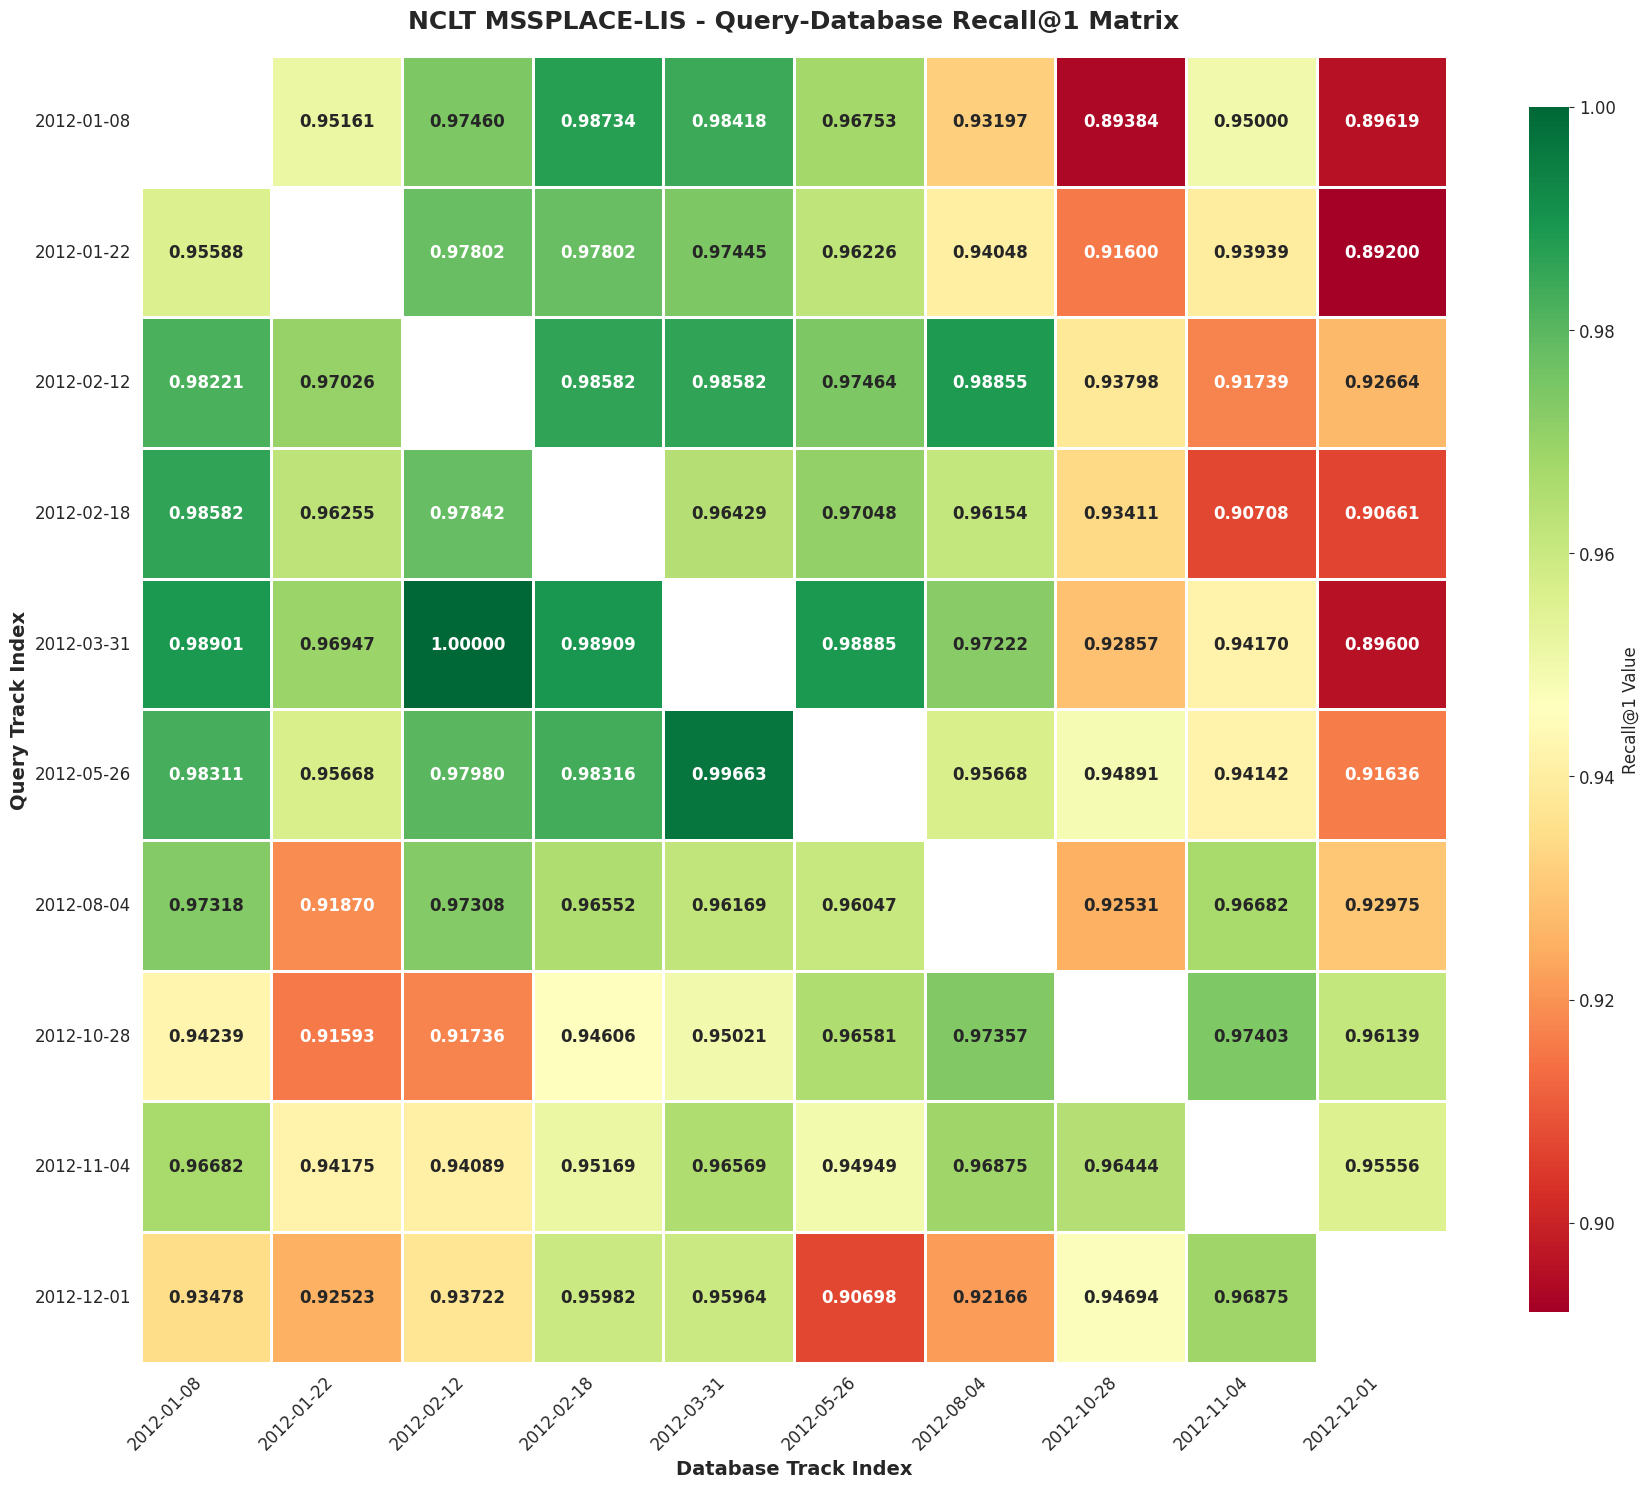


MATRIX PATTERN ANALYSIS

OVERALL SUCCESS RATE:
  0.9537666440010071

WORST QUERY TRACK:
  9

BEST QUERY TRACK:
  4

WORST DB TRACK:
  9

BEST DB TRACK:
  3

QUERY PERFORMANCE RANGE:
  (0.9401137, 0.96387917)

DB PERFORMANCE RANGE:
  (0.92005676, 0.97183585)


In [9]:
"""Create heatmap visualization and analyze matrix patterns."""


def create_recall_heatmap(
    recall_matrix: np.ndarray,
    track_labels: list[str] | None = None,
    figsize: tuple[int, int] = (16, 14),
    annotate_values: bool = True,
    value_format: str = ".2f",
    title: str = "Query-Database Recall@1 Correspondence Matrix",
) -> tuple[plt.Figure, plt.Axes]:
    """Create annotated heatmap of recall@1 matrix with white diagonal overlay."""
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate colormap range excluding diagonal for better contrast
    mask = ~np.eye(recall_matrix.shape[0], dtype=bool)
    off_diagonal_values = recall_matrix[mask]
    vmin = off_diagonal_values.min() if off_diagonal_values.size > 0 else 0.0
    vmax_val = 1.0

    print(f"Colormap range: {vmin:.3f} to {vmax_val:.3f}")

    # Create heatmap
    sns.heatmap(
        recall_matrix,
        annot=annotate_values,
        fmt=value_format,
        cmap="RdYlGn",
        vmin=vmin,
        vmax=vmax_val,
        square=True,
        linewidths=2,
        annot_kws={"weight": "bold"},
        cbar_kws={"label": "Recall@1 Value", "shrink": 0.8, "aspect": 30},
        xticklabels=track_labels,
        yticklabels=track_labels,
        ax=ax,
    )

    # White diagonal overlay (self-matches excluded from evaluation)
    for i in range(min(recall_matrix.shape)):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, facecolor="white", edgecolor="gray", alpha=1.0, lw=0))

    ax.set_title(title, fontsize=18, fontweight="bold", pad=20)
    ax.set_xlabel("Database Track Index", fontsize=14, fontweight="bold")
    ax.set_ylabel("Query Track Index", fontsize=14, fontweight="bold")

    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    ax.grid(True, which="major", color="white", linewidth=4, alpha=0.3)
    plt.tight_layout()

    return fig, ax


def analyze_matrix_patterns(recall_matrix: np.ndarray) -> dict[str, any]:
    """Analyze patterns to identify problematic tracks and systematic issues."""
    mask = ~np.eye(recall_matrix.shape[0], dtype=bool)
    off_diagonal = recall_matrix[mask]

    # Query performance (row-wise analysis)
    query_performance = np.array([recall_matrix[i, mask[i]].mean() for i in range(recall_matrix.shape[0])])

    # Database performance (column-wise analysis)
    db_performance = np.array([recall_matrix[mask[:, j], j].mean() for j in range(recall_matrix.shape[1])])

    return {
        "overall_success_rate": off_diagonal.mean(),
        "worst_query_track": int(np.argmin(query_performance)),
        "best_query_track": int(np.argmax(query_performance)),
        "worst_db_track": int(np.argmin(db_performance)),
        "best_db_track": int(np.argmax(db_performance)),
        "query_performance_range": (query_performance.min(), query_performance.max()),
        "db_performance_range": (db_performance.min(), db_performance.max()),
    }


# Create heatmap visualization
print("=" * 60)
print("CREATING RECALL@1 HEATMAP VISUALIZATION")
print("=" * 60)

fig, ax = create_recall_heatmap(
    recall_matrix=recall_matrix,
    track_labels=track_list,
    figsize=(18, 16),
    annotate_values=True,
    value_format=".5f",
    title=f"{DATASET.upper()} {MODEL_NAME.upper()} - Query-Database Recall@1 Matrix",
)

plt.show()

# Perform pattern analysis
pattern_analysis = analyze_matrix_patterns(recall_matrix)

print("\n" + "=" * 60)
print("MATRIX PATTERN ANALYSIS")
print("=" * 60)
for category, data in pattern_analysis.items():
    print(f"\n{category.upper().replace('_', ' ')}:")
    if isinstance(data, dict):
        for key, value in data.items():
            print(f"  {key.replace('_', ' ').title()}: {value}")
    else:
        print(f"  {data}")

## Worst Query-Database Pair Analysis

Identify and analyze the worst-performing query-database pairs based on lowest recall values. This helps pinpoint specific track combinations that consistently fail to retrieve relevant matches.


In [10]:
"""Identify and analyze the worst-performing query-database pair."""

# Find the worst-performing pair from the recall matrix
# mask = ~np.eye(recall_matrix.shape[0], dtype=bool)
worst_idx = np.unravel_index(np.argmin(recall_matrix), recall_matrix.shape)
worst_pair = {"query_id": worst_idx[0], "db_id": worst_idx[1]}

print(f"Worst performing pair: Query Track {worst_pair['query_id']} -> Database Track {worst_pair['db_id']}")
print(f"Recall@1: {recall_matrix[worst_pair['query_id'], worst_pair['db_id']]:.5f}")

# Find the corresponding RetrievalResults object
worst_results = None
for result in results.results:
    if result.query_track_id == worst_pair["query_id"] and result.database_track_id == worst_pair["db_id"]:
        worst_results = result
        break

if worst_results is not None:
    print("\nFound RetrievalResults for worst pair:")
    print(
        f"  Query Track: {worst_results.query_track_id} -> Database Track: {worst_results.database_track_id}"
    )
    print(f"  Recall@1: {worst_results.recall_at_n[0]:.5f}")
    print(f"  Recall@1%: {worst_results.recall_at_one_percent:.5f}")
    print(f"  Queries with matches: {worst_results.queries_with_matches}/{worst_results.num_queries}")
    print(f"  Distance threshold: {worst_results.distance_threshold}m")
    if worst_results.top1_distance is not None:
        print(f"  Mean top-1 distance: {worst_results.top1_distance:.3f}m")
else:
    print(
        f"ERROR: No RetrievalResults found for pair: query={worst_pair['query_id']}, db={worst_pair['db_id']}"
    )
    print("Available query-database pairs:")
    for result in results.results[:5]:
        print(f"  Query {result.query_track_id} -> Database {result.database_track_id}")
    print("  ...")

Worst performing pair: Query Track 1 -> Database Track 9
Recall@1: 0.89200

Found RetrievalResults for worst pair:
  Query Track: 1 -> Database Track: 9
  Recall@1: 0.89200
  Recall@1%: 0.94400
  Queries with matches: 250/275
  Distance threshold: 25.0m
  Mean top-1 distance: 4.415m


In [11]:
"""Detailed analysis of the worst-performing pair."""

if worst_results is not None:
    print("=" * 60)
    print("DETAILED FAILURE ANALYSIS")
    print("=" * 60)

    # Per-query performance analysis within this pair
    num_successful_queries = np.sum(worst_results.is_match[:, 0])  # Top-1 matches
    success_rate = num_successful_queries / worst_results.num_queries

    print("\nPer-Query Analysis:")
    print(f"  Total queries: {worst_results.num_queries}")
    print(f"  Successful top-1 matches: {num_successful_queries}")
    print(f"  Success rate: {success_rate:.3f} ({success_rate * 100:.1f}%)")

    # Distance statistics
    top1_distances = worst_results.embedding_distances[:, 0]
    geo_distances = worst_results.geographic_distances[:, 0]

    print("\nDistance Statistics:")
    print("  Embedding distances (top-1):")
    print(f"    Mean: {top1_distances.mean():.4f}")
    print(f"    Std:  {top1_distances.std():.4f}")
    print(f"    Min:  {top1_distances.min():.4f}")
    print(f"    Max:  {top1_distances.max():.4f}")

    print("  Geographic distances (top-1):")
    print(f"    Mean: {geo_distances.mean():.2f}m")
    print(f"    Std:  {geo_distances.std():.2f}m")
    print(f"    Min:  {geo_distances.min():.2f}m")
    print(f"    Max:  {geo_distances.max():.2f}m")

    # Identify most problematic individual queries
    failed_queries = np.where(~worst_results.is_match[:, 0])[0]

    if len(failed_queries) > 0:
        print("\nMost Problematic Queries:")
        print(f"  Total failed queries: {len(failed_queries)}")

        # Show worst 10 by embedding distance
        worst_indices = failed_queries[np.argsort(top1_distances[failed_queries])[-10:]]
        worst_indices_global = worst_results.query_indices[worst_indices]
        worst_db_matches = worst_results.retrieved_indices[worst_indices, 0]  # Top-1 matches
        worst_db_matches_global = worst_results.database_indices[worst_db_matches]

        print("  Worst 10 by embedding distance:")
        for idx in worst_indices:
            print(f"    Query {idx}: emb_dist={top1_distances[idx]:.4f}, geo_dist={geo_distances[idx]:.1f}m")

    print("\nTrack Information:")
    query_track_name = (
        track_list[worst_results.query_track_id]
        if worst_results.query_track_id < len(track_list)
        else "Unknown"
    )
    db_track_name = (
        track_list[worst_results.database_track_id]
        if worst_results.database_track_id < len(track_list)
        else "Unknown"
    )
    print(f"  Query Track {worst_results.query_track_id}: {query_track_name}")
    print(f"  Database Track {worst_results.database_track_id}: {db_track_name}")
else:
    print("Cannot perform detailed analysis - worst_results not found.")

DETAILED FAILURE ANALYSIS

Per-Query Analysis:
  Total queries: 275
  Successful top-1 matches: 223
  Success rate: 0.811 (81.1%)

Distance Statistics:
  Embedding distances (top-1):
    Mean: 4.9259
    Std:  1.5972
    Min:  2.2866
    Max:  10.1874
  Geographic distances (top-1):
    Mean: 30.72m
    Std:  69.66m
    Min:  0.21m
    Max:  409.09m

Most Problematic Queries:
  Total failed queries: 52
  Worst 10 by embedding distance:
    Query 234: emb_dist=8.6590, geo_dist=207.8m
    Query 230: emb_dist=8.7711, geo_dist=214.2m
    Query 8: emb_dist=8.9480, geo_dist=26.7m
    Query 11: emb_dist=8.9951, geo_dist=26.7m
    Query 9: emb_dist=9.1797, geo_dist=322.1m
    Query 201: emb_dist=9.5709, geo_dist=299.6m
    Query 231: emb_dist=9.6725, geo_dist=179.2m
    Query 10: emb_dist=9.8909, geo_dist=321.9m
    Query 232: emb_dist=9.9194, geo_dist=78.9m
    Query 233: emb_dist=10.1874, geo_dist=70.8m

Track Information:
  Query Track 1: 2012-01-22
  Database Track 9: 2012-12-01


In [12]:
"""Display worst database matches for inspection."""

# Check if variables exist from previous analysis
if "worst_db_matches_global" in locals():
    print(f"Worst database matches (global indices): {worst_db_matches_global}")
else:
    print("worst_db_matches_global not available - run previous analysis cell first")

Worst database matches (global indices): [2681 2667 2505 2505 2707 2537 2681 2707 2589 2589]


Worst query images:
Corresponding database match images:


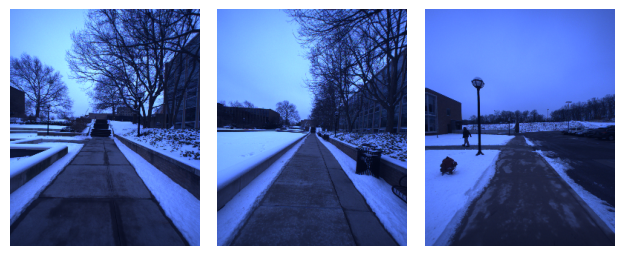

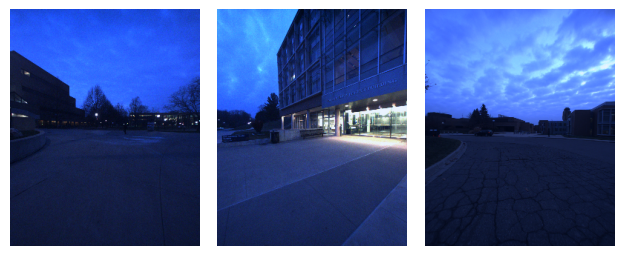

In [13]:
"""Visualize images from worst-performing queries and their database matches."""

# Check if required variables exist
if "worst_indices_global" in locals() and "worst_db_matches_global" in locals():
    # Load samples for worst queries and their database matches
    worst_queries = []
    db_matches = []

    for q_idx, db_idx in zip(worst_indices_global, worst_db_matches_global):
        try:
            worst_queries.append(dataset[q_idx])
            db_matches.append(dataset[db_idx])
        except IndexError as e:
            print(f"Warning: Could not load sample at index {q_idx} or {db_idx}: {e}")

    # Extract images for visualization (using Cam5 for NCLT, adjust for other datasets)
    image_key = "image_Cam5" if DATASET == "nclt" else "image_stereo_centre"

    if worst_queries:
        worst_queries_images = [sample[image_key] for sample in worst_queries if image_key in sample]
        if worst_queries_images:
            print("Worst query images:")
            ts.show(worst_queries_images[:3])
        else:
            print(f"No images found with key '{image_key}' in worst queries")

    if db_matches:
        worst_db_matches_images = [sample[image_key] for sample in db_matches if image_key in sample]
        if worst_db_matches_images:
            print("Corresponding database match images:")
            ts.show(worst_db_matches_images[:3])
        else:
            print(f"No images found with key '{image_key}' in database matches")

else:
    print("Required variables not available - run previous analysis cells first")

## Top Errors on the Whole Dataset

Analyze the most problematic queries across all query-database pairs by collecting failed top-1 predictions and ranking them by embedding distance. This provides a global view of the hardest failure cases in the entire evaluation.

In [14]:
"""Collect and analyze top-1 prediction errors across all query-database pairs."""


@dataclass
class QueryError:
    """Represents a single failed query with comprehensive error information."""

    query_global_idx: int
    database_match_global_idx: int
    embedding_distance: float
    geographic_distance: float
    query_track_id: int
    database_track_id: int
    query_local_idx: int


def collect_all_errors(results: RetrievalResultsCollection) -> list[QueryError]:
    """
    Collect all top-1 prediction errors across all query-database pairs.

    Iterates through all query-database pairs and identifies every failed top-1 prediction,
    storing comprehensive information about each error for global analysis.

    Args:
        results: Collection of retrieval results for all query-database pairs

    Returns:
        List of QueryError objects sorted by embedding distance (worst first)
    """
    all_errors = []

    print(f"Analyzing {len(results.results)} query-database pairs...")

    for pair_idx, result in enumerate(results.results):
        # Identify failed top-1 predictions in this pair
        failed_queries = np.where(~result.is_match[:, 0])[0]

        if len(failed_queries) > 0:
            # Extract comprehensive information for each failed query
            for local_idx in failed_queries:
                error = QueryError(
                    query_global_idx=result.query_indices[local_idx],
                    database_match_global_idx=result.retrieved_indices[local_idx, 0],
                    embedding_distance=result.embedding_distances[local_idx, 0],
                    geographic_distance=result.geographic_distances[local_idx, 0],
                    query_track_id=result.query_track_id,
                    database_track_id=result.database_track_id,
                    query_local_idx=local_idx,
                )
                all_errors.append(error)

        if (pair_idx + 1) % 10 == 0:
            print(f"  Processed {pair_idx + 1}/{len(results.results)} pairs...")

    # Sort by embedding distance (worst errors first)
    all_errors.sort(key=lambda x: x.embedding_distance, reverse=True)

    print(f"\nCollected {len(all_errors)} total errors across all pairs")
    return all_errors


# Collect all errors from the dataset
all_dataset_errors = collect_all_errors(results)

# Display comprehensive summary statistics
if all_dataset_errors:
    print("\nGlobal Error Analysis Summary:")
    print(f"  Total failed queries: {len(all_dataset_errors)}")

    # Embedding distance statistics
    embedding_distances = [error.embedding_distance for error in all_dataset_errors]
    print("  Embedding distance statistics:")
    print(f"    Mean: {np.mean(embedding_distances):.4f}")
    print(f"    Std:  {np.std(embedding_distances):.4f}")
    print(f"    Min:  {np.min(embedding_distances):.4f}")
    print(f"    Max:  {np.max(embedding_distances):.4f}")

    # Geographic distance statistics
    geo_distances = [error.geographic_distance for error in all_dataset_errors]
    print("  Geographic distance statistics:")
    print(f"    Mean: {np.mean(geo_distances):.2f}m")
    print(f"    Std:  {np.std(geo_distances):.2f}m")
    print(f"    Min:  {np.min(geo_distances):.2f}m")
    print(f"    Max:  {np.max(geo_distances):.2f}m")

    # Track distribution analysis
    track_pairs = [(error.query_track_id, error.database_track_id) for error in all_dataset_errors]
    unique_pairs = list(set(track_pairs))
    print("  Track pair distribution:")
    print(f"    Unique query-database pairs with errors: {len(unique_pairs)}")
    print(f"    Average errors per pair: {len(all_dataset_errors) / len(unique_pairs):.1f}")
else:
    print("No errors found in the dataset!")

Analyzing 90 query-database pairs...
  Processed 10/90 pairs...
  Processed 20/90 pairs...
  Processed 30/90 pairs...
  Processed 40/90 pairs...
  Processed 50/90 pairs...
  Processed 60/90 pairs...
  Processed 70/90 pairs...
  Processed 80/90 pairs...
  Processed 90/90 pairs...

Collected 2799 total errors across all pairs

Global Error Analysis Summary:
  Total failed queries: 2799
  Embedding distance statistics:
    Mean: 6.9608
    Std:  1.3876
    Min:  2.4759
    Max:  12.5845
  Geographic distance statistics:
    Mean: 188.02m
    Std:  139.14m
    Min:  25.01m
    Max:  525.77m
  Track pair distribution:
    Unique query-database pairs with errors: 90
    Average errors per pair: 31.1


In [15]:
"""Analyze and visualize the worst errors in detail."""


def analyze_top_errors(errors: list[QueryError], top_k: int = 20) -> pd.DataFrame:
    """
    Create detailed analysis of the top-k worst errors.

    Args:
        errors: List of QueryError objects (should be sorted by embedding distance)
        top_k: Number of worst errors to analyze in detail

    Returns:
        DataFrame with detailed information about top errors
    """
    if not errors:
        print("No errors to analyze")
        return pd.DataFrame()

    # Take top-k worst errors
    worst_errors = errors[:top_k]

    # Create detailed DataFrame
    error_data = []
    for i, error in enumerate(worst_errors):
        query_track_name = (
            track_list[error.query_track_id] if error.query_track_id < len(track_list) else "Unknown"
        )
        db_track_name = (
            track_list[error.database_track_id] if error.database_track_id < len(track_list) else "Unknown"
        )

        error_data.append(
            {
                "rank": i + 1,
                "query_global_idx": error.query_global_idx,
                "db_match_global_idx": error.database_match_global_idx,
                "embedding_distance": error.embedding_distance,
                "geographic_distance": error.geographic_distance,
                "query_track_id": error.query_track_id,
                "query_track_name": query_track_name,
                "database_track_id": error.database_track_id,
                "database_track_name": db_track_name,
                "query_local_idx": error.query_local_idx,
            }
        )

    return pd.DataFrame(error_data)


def create_error_summary_table(errors: list[QueryError]) -> pd.DataFrame:
    """Create summary table of errors by track pairs."""
    if not errors:
        return pd.DataFrame()

    # Group errors by track pairs
    pair_errors = {}
    for error in errors:
        pair_key = (error.query_track_id, error.database_track_id)
        if pair_key not in pair_errors:
            pair_errors[pair_key] = []
        pair_errors[pair_key].append(error)

    # Create summary statistics
    summary_data = []
    for (q_track, db_track), track_errors in pair_errors.items():
        embedding_dists = [e.embedding_distance for e in track_errors]
        geo_dists = [e.geographic_distance for e in track_errors]

        q_track_name = track_list[q_track] if q_track < len(track_list) else "Unknown"
        db_track_name = track_list[db_track] if db_track < len(track_list) else "Unknown"

        summary_data.append(
            {
                "query_track_id": q_track,
                "query_track_name": q_track_name,
                "database_track_id": db_track,
                "database_track_name": db_track_name,
                "num_errors": len(track_errors),
                "mean_embedding_dist": np.mean(embedding_dists),
                "max_embedding_dist": np.max(embedding_dists),
                "mean_geo_dist": np.mean(geo_dists),
                "max_geo_dist": np.max(geo_dists),
            }
        )

    # Sort by number of errors (descending)
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values("num_errors", ascending=False)

    return summary_df


# Analyze top 20 worst errors in detail
print("=" * 60)
print("TOP 20 WORST ERRORS ANALYSIS")
print("=" * 60)

if all_dataset_errors:
    top_errors_df = analyze_top_errors(all_dataset_errors, top_k=20)

    print("\nTop 20 worst errors by embedding distance:")
    print(top_errors_df.to_string(index=False, float_format="%.4f"))

    # Summary by track pairs
    print("\n" + "=" * 60)
    print("ERROR SUMMARY BY TRACK PAIRS")
    print("=" * 60)

    summary_df = create_error_summary_table(all_dataset_errors)
    print("\nTrack pairs with most errors:")
    print(summary_df.head(10).to_string(index=False, float_format="%.4f"))

    # Store for potential visualization
    print("\nData stored in variables:")
    print(f"  all_dataset_errors: {len(all_dataset_errors)} total errors")
    print("  top_errors_df: Top 20 worst errors DataFrame")
    print("  summary_df: Summary by track pairs DataFrame")
else:
    print("No errors found to analyze")

TOP 20 WORST ERRORS ANALYSIS

Top 20 worst errors by embedding distance:
 rank  query_global_idx  db_match_global_idx  embedding_distance  geographic_distance  query_track_id query_track_name  database_track_id database_track_name  query_local_idx
    1               531                  169             12.5845             189.3289               1       2012-01-22                  5          2012-05-26              200
    2               530                  169             12.3643             186.4547               1       2012-01-22                  5          2012-05-26              199
    3              1940                  275             12.3376             233.7283               6       2012-08-04                  5          2012-05-26              197
    4               907                  211             11.7632             320.4577               3       2012-02-18                  9          2012-12-01               19
    5              2522                  219        

VISUALIZING WORST GLOBAL ERRORS
Visualizing 3 worst global errors:

Error #1 - Embedding Distance: 12.5845
  Query: Track 1 (2012-01-22)
  Database Match: Track 5 (2012-05-26)
  Geographic Distance: 189.33m
  Global Indices: Query=531, DB=169
  Query Image (Global Index 531):
  Database Match Image (Global Index 169):
----------------------------------------

Error #2 - Embedding Distance: 12.3643
  Query: Track 1 (2012-01-22)
  Database Match: Track 5 (2012-05-26)
  Geographic Distance: 186.45m
  Global Indices: Query=530, DB=169
  Query Image (Global Index 530):
  Database Match Image (Global Index 169):
----------------------------------------

Error #3 - Embedding Distance: 12.3376
  Query: Track 6 (2012-08-04)
  Database Match: Track 5 (2012-05-26)
  Geographic Distance: 233.73m
  Global Indices: Query=1940, DB=275
  Query Image (Global Index 1940):
  Database Match Image (Global Index 275):
----------------------------------------

EXPORT OPTIONS
To export all errors to CSV, unco

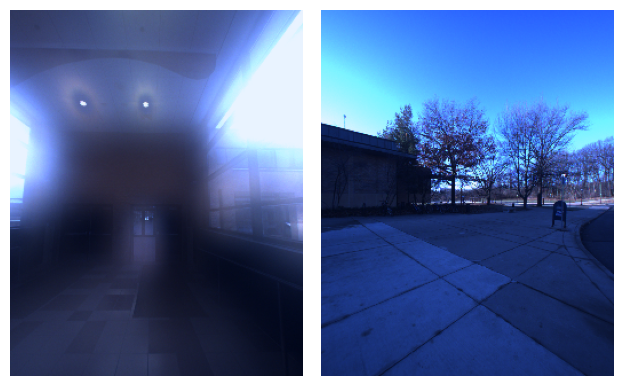

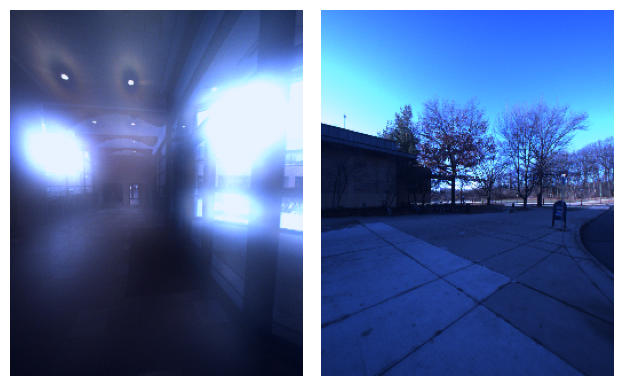

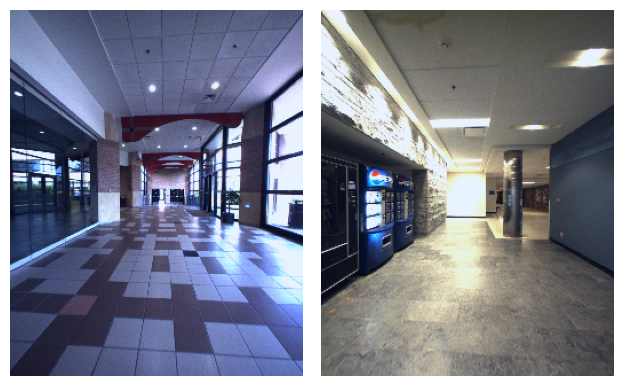

In [16]:
"""Visualize the worst global errors with side-by-side image comparison."""


def visualize_worst_global_errors(errors: list[QueryError], num_errors: int = 5):
    """
    Visualize the worst global errors by showing query and database match images.

    Args:
        errors: List of QueryError objects sorted by embedding distance
        num_errors: Number of worst errors to visualize
    """
    if not errors:
        print("No errors to visualize")
        return

    # Select worst errors
    worst_errors = errors[:num_errors]

    print(f"Visualizing {len(worst_errors)} worst global errors:")
    print("=" * 60)

    # Determine image key based on dataset
    image_key = "image_Cam5" if DATASET == "nclt" else "image_stereo_centre"

    for i, error in enumerate(worst_errors):
        print(f"\nError #{i + 1} - Embedding Distance: {error.embedding_distance:.4f}")
        print(
            f"  Query: Track {error.query_track_id} ({track_list[error.query_track_id] if error.query_track_id < len(track_list) else 'Unknown'})"
        )
        print(
            f"  Database Match: Track {error.database_track_id} ({track_list[error.database_track_id] if error.database_track_id < len(track_list) else 'Unknown'})"
        )
        print(f"  Geographic Distance: {error.geographic_distance:.2f}m")
        print(f"  Global Indices: Query={error.query_global_idx}, DB={error.database_match_global_idx}")

        try:
            # Load query and database match samples
            query_sample = dataset[error.query_global_idx]
            db_sample = dataset[error.database_match_global_idx]

            # Extract images if available
            if image_key in query_sample and image_key in db_sample:
                print(f"  Query Image (Global Index {error.query_global_idx}):")
                print(f"  Database Match Image (Global Index {error.database_match_global_idx}):")
                ts.show([query_sample[image_key], db_sample[image_key]])
            else:
                print(f"  Images not available for key '{image_key}'")

        except IndexError as e:
            print(f"  Error loading samples: {e}")

        print("-" * 40)


def export_error_data(errors: list[QueryError], filename: str = "global_errors.csv"):
    """
    Export error data to CSV for further analysis.

    Args:
        errors: List of QueryError objects
        filename: Output CSV filename
    """
    if not errors:
        print("No errors to export")
        return

    # Convert to DataFrame
    export_data = []
    for i, error in enumerate(errors):
        query_track_name = (
            track_list[error.query_track_id] if error.query_track_id < len(track_list) else "Unknown"
        )
        db_track_name = (
            track_list[error.database_track_id] if error.database_track_id < len(track_list) else "Unknown"
        )

        export_data.append(
            {
                "rank": i + 1,
                "query_global_idx": error.query_global_idx,
                "database_match_global_idx": error.database_match_global_idx,
                "embedding_distance": error.embedding_distance,
                "geographic_distance": error.geographic_distance,
                "query_track_id": error.query_track_id,
                "query_track_name": query_track_name,
                "database_track_id": error.database_track_id,
                "database_track_name": db_track_name,
                "query_local_idx": error.query_local_idx,
            }
        )

    export_df = pd.DataFrame(export_data)
    output_path = Path(filename)
    export_df.to_csv(output_path, index=False)
    print(f"Exported {len(errors)} errors to: {output_path.absolute()}")
    return export_df


# Visualize worst 3 global errors
print("VISUALIZING WORST GLOBAL ERRORS")
print("=" * 60)

if all_dataset_errors:
    visualize_worst_global_errors(all_dataset_errors, num_errors=3)

    # Optional: Export all errors to CSV
    print("\n" + "=" * 60)
    print("EXPORT OPTIONS")
    print("=" * 60)
    print("To export all errors to CSV, uncomment the following line:")
    print("# export_df = export_error_data(all_dataset_errors, 'global_errors.csv')")
else:
    print("No errors available for visualization")

## Common errors for all models


In [17]:
mssplace_lis_results_file = RESULTS_DIR / "nclt_mssplace-lis_results_20250525_165818.json"
mssplace_i_results_file = RESULTS_DIR / "nclt_mssplace-i_results_20250527_211537.json"
mixvpr_results_file = RESULTS_DIR / "nclt_mixvpr_results_20250527_131802.json"
minklocpp_results_file = RESULTS_DIR / "nclt_minkloc-multimodal_results_20250527_160320.json"
minkloc3dv2_results_file = RESULTS_DIR / "nclt_minkloc3dv2_results_20250527_160708.json"

assert mssplace_lis_results_file.exists(), f"File not found: {mssplace_lis_results_file}"
assert mssplace_i_results_file.exists(), f"File not found: {mssplace_i_results_file}"
assert mixvpr_results_file.exists(), f"File not found: {mixvpr_results_file}"
assert minklocpp_results_file.exists(), f"File not found: {minklocpp_results_file}"
assert minkloc3dv2_results_file.exists(), f"File not found: {minkloc3dv2_results_file}"


In [18]:
mssplace_lis_results = RetrievalResultsCollection.load(mssplace_lis_results_file)
mssplace_i_results = RetrievalResultsCollection.load(mssplace_i_results_file)
mixvpr_results = RetrievalResultsCollection.load(mixvpr_results_file)
minklocpp_results = RetrievalResultsCollection.load(minklocpp_results_file)
minkloc3dv2_results = RetrievalResultsCollection.load(minkloc3dv2_results_file)

In [19]:
"""Collect errors from all models for comparison analysis."""

# Collect errors from each model using the existing function
print("Collecting errors from all models...")
print("\n" + "=" * 60)

mssplace_lis_errors = collect_all_errors(mssplace_lis_results)
print(f"MSSPlace-LIS errors: {len(mssplace_lis_errors)}")
print("\n" + "=" * 60 + "\n")

mssplace_i_errors = collect_all_errors(mssplace_i_results)
print(f"MSSPlace-I errors: {len(mssplace_i_errors)}")
print("\n" + "=" * 60 + "\n")

mixvpr_errors = collect_all_errors(mixvpr_results)
print(f"MixVPR errors: {len(mixvpr_errors)}")
print("\n" + "=" * 60 + "\n")

minklocpp_errors = collect_all_errors(minklocpp_results)
print(f"MinkLoc++ errors: {len(minklocpp_errors)}")
print("\n" + "=" * 60 + "\n")

minkloc3dv2_errors = collect_all_errors(minkloc3dv2_results)
print(f"MinkLoc3Dv2 errors: {len(minkloc3dv2_errors)}")
print("\n" + "=" * 60 + "\n")

# Store all model errors in a dictionary for easier analysis
all_model_errors = {
    "MSSPlace-LIS": mssplace_lis_errors,
    "MSSPlace-I": mssplace_i_errors,
    "MixVPR": mixvpr_errors,
    "MinkLoc++": minklocpp_errors,
    "MinkLoc3Dv2": minkloc3dv2_errors,
}

print(f"\nTotal errors across all models: {sum(len(errors) for errors in all_model_errors.values())}")


Analyzing 90 query-database pairs...
  Processed 10/90 pairs...
  Processed 20/90 pairs...
  Processed 30/90 pairs...
  Processed 40/90 pairs...
  Processed 50/90 pairs...
  Processed 60/90 pairs...
  Processed 70/90 pairs...
  Processed 80/90 pairs...
  Processed 90/90 pairs...

Collected 2799 total errors across all pairs
MSSPlace-LIS errors: 2799


Analyzing 90 query-database pairs...
  Processed 10/90 pairs...
  Processed 20/90 pairs...
  Processed 30/90 pairs...
  Processed 40/90 pairs...
  Processed 50/90 pairs...
  Processed 60/90 pairs...
  Processed 70/90 pairs...
  Processed 80/90 pairs...
  Processed 90/90 pairs...

Collected 4347 total errors across all pairs
MSSPlace-I errors: 4347


Analyzing 90 query-database pairs...
  Processed 10/90 pairs...
  Processed 20/90 pairs...
  Processed 30/90 pairs...
  Processed 40/90 pairs...
  Processed 50/90 pairs...
  Processed 60/90 pairs...
  Processed 70/90 pairs...
  Processed 80/90 pairs...
  Processed 90/90 pairs...

Collected 71

In [20]:
"""Analyze track pairs to find queries that constantly fail across ALL models."""


def analyze_track_pair_constant_failures(all_model_errors: dict) -> dict:
    """
    Find queries that constantly fail across ALL models within each track pair.

    This analysis groups errors by track pairs (query_track_id, database_track_id)
    and identifies queries that fail in ALL models for each track pair.
    It records the actual top-1 database match for each model.

    Args:
        all_model_errors: Dictionary mapping model names to their error lists

    Returns:
        Dictionary with structure:
        {
            track_pair: {
                'failing_queries': [
                    {
                        'query_id': int,
                        'model_matches': {
                            model_name: {
                                'db_match_id': int,
                                'embedding_dist': float,
                                'geographic_dist': float,
                                'query_global_idx': int,
                                'db_match_global_idx': int
                            }
                        }
                    }
                ]
            }
        }
    """

    print("=" * 70)
    print("TRACK PAIR CONSTANT FAILURE ANALYSIS")
    print("=" * 70)

    # Step 1: Group errors by track pairs and queries within each pair
    track_pair_analysis = {}  # {(query_track_id, db_track_id): {query_id: {model: error}}}

    for model_name, errors in all_model_errors.items():
        print(f"Processing {model_name}: {len(errors)} errors")

        for error in errors:
            track_pair = (error.query_track_id, error.database_track_id)
            query_id = error.query_global_idx

            # Initialize nested dictionaries if needed
            if track_pair not in track_pair_analysis:
                track_pair_analysis[track_pair] = {}
            if query_id not in track_pair_analysis[track_pair]:
                track_pair_analysis[track_pair][query_id] = {}

            # Store error information for this model
            track_pair_analysis[track_pair][query_id][model_name] = error

    print(f"\nFound {len(track_pair_analysis)} unique track pairs with errors")

    # Step 2: Find queries that fail in ALL models within each track pair
    num_models = len(all_model_errors)
    constant_failures = {}

    mssplace_failures = {}  # Special case for MSSPlace-LIS and MSSPlace-I failures

    total_track_pairs = 0
    track_pairs_with_constant_failures = 0
    total_constantly_failing_queries = 0

    track_pairs_with_mssplace_failures = 0
    total_mssplace_failing_queries = 0

    for track_pair, queries_errors in track_pair_analysis.items():
        query_track_id, db_track_id = track_pair

        # Find queries that have errors in ALL models
        constantly_failing_queries = []

        # Find queries that fail only in MSSPlace-LIS and MSSPlace-I, but not in MixVPR, MinkLoc++, or MinkLoc3Dv2
        mssplace_failing_queries = []

        for query_id, model_errors in queries_errors.items():
            if len(model_errors) == num_models:  # Query fails in ALL models
                # Prepare model match information
                model_matches = {}
                for model_name, error in model_errors.items():
                    model_matches[model_name] = {
                        "db_match_id": error.database_match_global_idx,
                        "embedding_dist": error.embedding_distance,
                        "geographic_dist": error.geographic_distance,
                        "query_global_idx": error.query_global_idx,
                        "db_match_global_idx": error.database_match_global_idx,
                    }

                constantly_failing_queries.append({"query_id": query_id, "model_matches": model_matches})
            elif (
                len(model_errors) == 2
                and "MSSPlace-LIS" in model_errors
                and "MSSPlace-I" in model_errors
                and all(
                    model_name not in model_errors for model_name in ["MixVPR", "MinkLoc++", "MinkLoc3Dv2"]
                )
            ):
                # Special case: query fails only in MSSPlace-LIS and MSSPlace-I
                # Prepare model match information
                model_matches = {}
                for model_name, error in model_errors.items():
                    model_matches[model_name] = {
                        "db_match_id": error.database_match_global_idx,
                        "embedding_dist": error.embedding_distance,
                        "geographic_dist": error.geographic_distance,
                        "query_global_idx": error.query_global_idx,
                        "db_match_global_idx": error.database_match_global_idx,
                    }

                mssplace_failing_queries.append({"query_id": query_id, "model_matches": model_matches})

        # Store track pair results if there are constantly failing queries
        if constantly_failing_queries:
            constant_failures[track_pair] = {"failing_queries": constantly_failing_queries}
            track_pairs_with_constant_failures += 1
            total_constantly_failing_queries += len(constantly_failing_queries)
        elif mssplace_failing_queries:
            # Store MSSPlace-LIS and MSSPlace-I failures separately
            mssplace_failures[track_pair] = {"failing_queries": mssplace_failing_queries}
            track_pairs_with_mssplace_failures += 1
            total_mssplace_failing_queries += len(mssplace_failing_queries)

        total_track_pairs += 1

    # Step 3: Print summary statistics
    print(f"\n📊 CONSTANT FAILURE ANALYSIS RESULTS:")
    print("-" * 50)
    print(f"Track pairs analyzed: {total_track_pairs}")
    print(f"Track pairs with constant failures: {track_pairs_with_constant_failures}")
    print(f"Total queries constantly failing: {total_constantly_failing_queries}")

    if track_pairs_with_constant_failures > 0:
        avg_failures_per_pair = total_constantly_failing_queries / track_pairs_with_constant_failures
        print(f"Average constantly failing queries per affected pair: {avg_failures_per_pair:.1f}")

        # Show top track pairs by number of constantly failing queries
        sorted_pairs = sorted(
            constant_failures.items(), key=lambda x: len(x[1]["failing_queries"]), reverse=True
        )

        print("\nTop track pairs by constantly failing queries:")
        for i, (track_pair, data) in enumerate(sorted_pairs[:5]):
            query_track_id, db_track_id = track_pair
            num_failures = len(data["failing_queries"])
            print(
                f"  {i + 1}. Track {query_track_id} → Track {db_track_id}: {num_failures} constantly failing queries"
            )

    if track_pairs_with_mssplace_failures > 0:
        avg_failures_per_pair = total_mssplace_failing_queries / track_pairs_with_mssplace_failures
        print(f"Average MSSPlace failing queries per affected pair: {avg_failures_per_pair:.1f}")

        # Show top MSSPlace track pairs by number of constantly failing queries
        sorted_mssplace_pairs = sorted(
            mssplace_failures.items(), key=lambda x: len(x[1]["failing_queries"]), reverse=True
        )

        print("\nTop track pairs by MSSPlace failing queries:")
        for i, (track_pair, data) in enumerate(sorted_mssplace_pairs[:5]):
            query_track_id, db_track_id = track_pair
            num_failures = len(data["failing_queries"])
            print(
                f"  {i + 1}. Track {query_track_id} → Track {db_track_id}: {num_failures} MSSPlace failing queries"
            )

    return {
        "constant_failures": constant_failures,
        "mssplace_failures": mssplace_failures,
        "summary": {
            "total_track_pairs": total_track_pairs,
            "track_pairs_with_constant_failures": track_pairs_with_constant_failures,
            "total_constantly_failing_queries": total_constantly_failing_queries,
            "track_pairs_with_mssplace_failures": track_pairs_with_mssplace_failures,
            "total_mssplace_failing_queries": total_mssplace_failing_queries,
            "models_analyzed": list(all_model_errors.keys()),
        },
    }


# Perform the track pair constant failure analysis
track_pair_analysis = analyze_track_pair_constant_failures(all_model_errors)

# Print results
print("\n🔍 TRACK PAIR CONSTANT FAILURE ANALYSIS COMPLETE\n")
constant_failures = track_pair_analysis["constant_failures"]
mssplace_failures = track_pair_analysis["mssplace_failures"]
summary = track_pair_analysis["summary"]

# Display detailed results for top track pairs
if constant_failures:
    print(f"Found {len(constant_failures)} track pairs with constantly failing queries:")
    print("=" * 80)

    # Sort track pairs by number of constantly failing queries
    sorted_track_pairs = sorted(
        constant_failures.items(), key=lambda x: len(x[1]["failing_queries"]), reverse=True
    )

    for i, (track_pair, data) in enumerate(sorted_track_pairs[:10]):  # Show top 10
        query_track_id, db_track_id = track_pair
        failing_queries = data["failing_queries"]

        print(f"\n📍 TRACK PAIR {i + 1}: Query Track {query_track_id} → Database Track {db_track_id}")
        print(f"    Constantly failing queries: {len(failing_queries)}")
        print("-" * 60)

        # Show details for each constantly failing query
        for j, query_data in enumerate(failing_queries[:5]):  # Show first 5 queries per track pair
            query_id = query_data["query_id"]
            model_matches = query_data["model_matches"]

            print(f"  🔸 Query {query_id} (fails in all {len(model_matches)} models):")

            # Show actual retrieval results from each model
            for model_name, match_data in model_matches.items():
                db_match_id = match_data["db_match_id"]
                emb_dist = match_data["embedding_dist"]
                geo_dist = match_data["geographic_dist"]

                print(
                    f"      🤖 {model_name:15s}: retrieved DB {db_match_id}, "
                    f"emb_dist={emb_dist:.4f}, geo_dist={geo_dist:6.1f}m"
                )

            if j == 4 and len(failing_queries) > 5:
                print(f"      ... and {len(failing_queries) - 5} more constantly failing queries")
                break

        if i == 9 and len(sorted_track_pairs) > 10:
            print(f"\n... and {len(sorted_track_pairs) - 10} more track pairs with constant failures")
            break
else:
    print("✅ No track pairs found where queries constantly fail across all models!")


TRACK PAIR CONSTANT FAILURE ANALYSIS
Processing MSSPlace-LIS: 2799 errors
Processing MSSPlace-I: 4347 errors
Processing MixVPR: 7194 errors
Processing MinkLoc++: 3626 errors
Processing MinkLoc3Dv2: 3903 errors

Found 90 unique track pairs with errors

📊 CONSTANT FAILURE ANALYSIS RESULTS:
--------------------------------------------------
Track pairs analyzed: 90
Track pairs with constant failures: 85
Total queries constantly failing: 2145
Average constantly failing queries per affected pair: 25.2

Top track pairs by constantly failing queries:
  1. Track 0 → Track 8: 77 constantly failing queries
  2. Track 3 → Track 8: 66 constantly failing queries
  3. Track 5 → Track 8: 64 constantly failing queries
  4. Track 2 → Track 8: 61 constantly failing queries
  5. Track 4 → Track 8: 58 constantly failing queries
Average MSSPlace failing queries per affected pair: 1.8

Top track pairs by MSSPlace failing queries:
  1. Track 2 → Track 4: 3 MSSPlace failing queries
  2. Track 5 → Track 3: 2 M

In [21]:
selected_failures = [
    track_pair_analysis["constant_failures"][(0, 9)]["failing_queries"][4],
    track_pair_analysis["constant_failures"][(9, 5)]["failing_queries"][36],
    track_pair_analysis["constant_failures"][(4, 2)]["failing_queries"][0],
    track_pair_analysis["constant_failures"][(6, 1)]["failing_queries"][12],
    track_pair_analysis["constant_failures"][(0, 7)]["failing_queries"][4],
    track_pair_analysis["constant_failures"][(0, 7)]["failing_queries"][33],
]

In [22]:
for i, failure in enumerate(selected_failures):
    save_dir = Path.cwd() / "evaluation_results" / "selected_failures" / f"query_{i}"
    save_dir.mkdir(parents=True, exist_ok=True)

    query_id = failure["query_id"]
    model_matches = failure["model_matches"]

    query_image = dataset[query_id]["image_Cam5"]
    query_pc = dataset[query_id]["pointcloud_lidar_coords"]
    ts.save(query_image, save_dir / "query.png")
    plot_and_save_pc(query_pc, save_dir / "query_pc.png")

    for model_name, match_data in model_matches.items():
        db_match_id = match_data["db_match_id"]
        emb_dist = match_data["embedding_dist"]
        geo_dist = match_data["geographic_dist"]

        db_image = dataset[db_match_id]["image_Cam5"]
        db_pc = dataset[db_match_id]["pointcloud_lidar_coords"]
        ts.save(db_image, save_dir /f"db_match_{model_name}.png")
        plot_and_save_pc(db_pc, save_dir / f"db_match_{model_name}_pc.png")

print(f"Selected failures saved to: {save_dir.parent.absolute()}")

Selected failures saved to: /home/docker_mssplace/MSSPlace/scripts/evaluation/evaluation_results/selected_failures
